This will explore the previously parsed Zooniverse annotated data.

In [176]:
data_file = './zooniverse/cleaned_zooniverse.csv' # cleaned zooniverse data

dir_api = './example_hists/LLM_outputs/chatgpt_api/'

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob
import seaborn as sns

In [178]:
df = pd.read_csv(data_file)

In [179]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50


### Annotator 1

In [180]:
df_a1 = df[df['annotators']=='annotator1']

len(df_a1)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

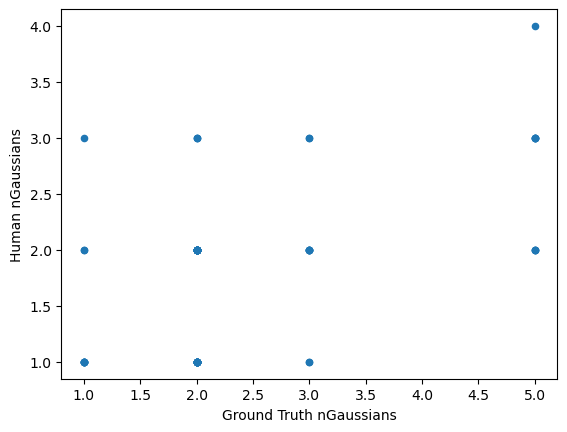

In [181]:
df_a1.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

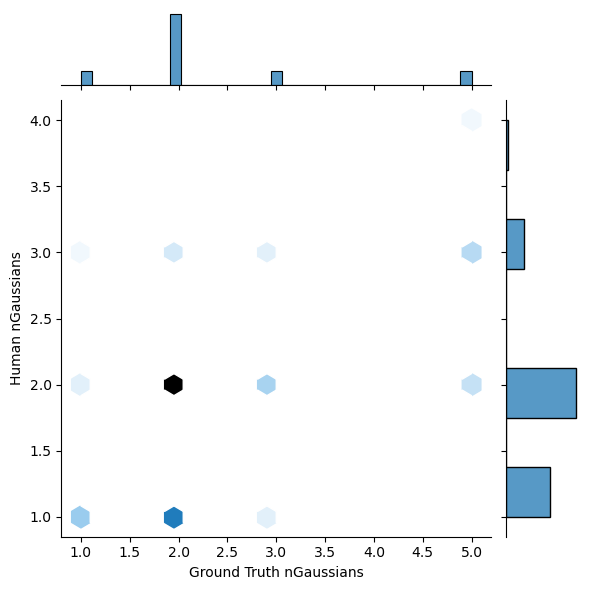

In [182]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df_a1, kind='hex')

(-0.8, 0.9)

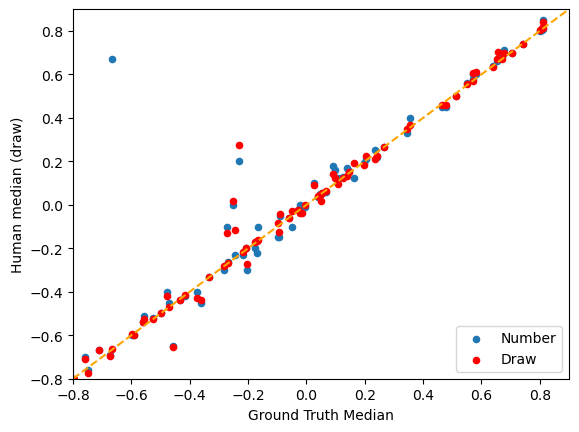

In [183]:
ax = df_a1.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a1.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

# draw line of what it should be
ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [184]:
diff1 = (np.abs(df_a1['Ground Truth Median']-df_a1['Human median (draw)']))/np.abs(df_a1['Ground Truth Median'])

np.mean(diff1), np.std(diff1)

(0.19298121815362174, 0.42507057171782764)

In [185]:
q1 = np.percentile(diff1, 25)
q3 = np.percentile(diff1, 75)

iqr = q3 - q1

np.median(diff1), iqr

(0.0364671267337863, 0.11682488786479395)

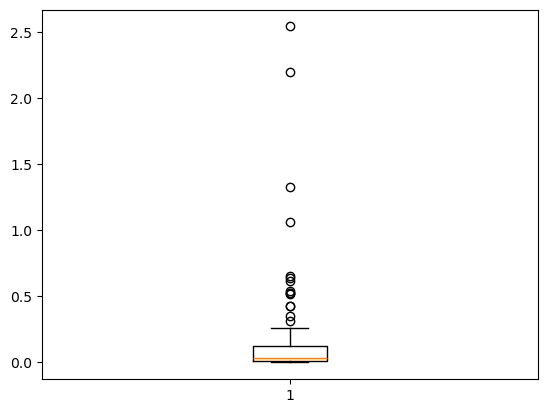

In [186]:
plt.boxplot(diff1)
plt.show()

### Annotator 2

In [187]:
df_a2 = df[df['annotators']=='annotator2']

len(df_a2)

80

<Axes: xlabel='Ground Truth nGaussians', ylabel='Human nGaussians'>

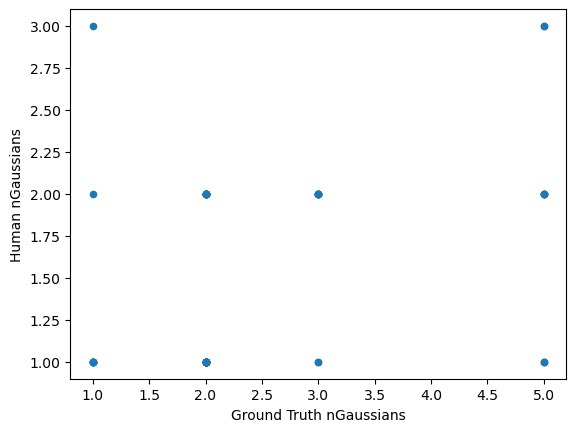

In [188]:
df_a2.plot(x='Ground Truth nGaussians', y='Human nGaussians', kind='scatter')

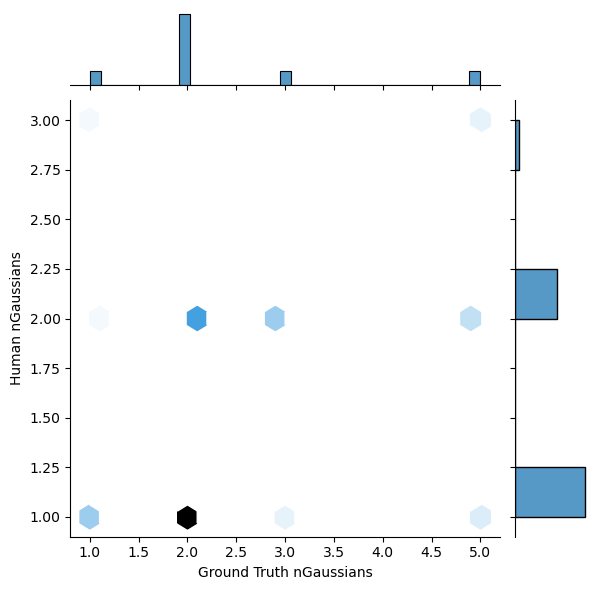

In [189]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df_a2, kind='hex')

(-0.8, 0.9)

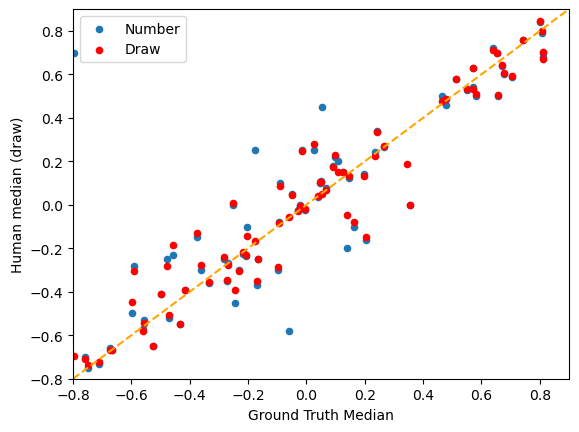

In [190]:
ax = df_a2.plot(x='Ground Truth Median', y='Human median (number)', kind='scatter', label='Number')
df_a2.plot(x='Ground Truth Median', y='Human median (draw)', kind='scatter', label='Draw', ax=ax, color='red')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

In [191]:
diff2 = (np.abs(df_a2['Ground Truth Median']-df_a2['Human median (draw)']))/np.abs(df_a2['Ground Truth Median'])

np.mean(diff2), np.std(diff2)

(0.7191192015889002, 2.132788369224864)

In [192]:
q1 = np.percentile(diff2, 25)
q3 = np.percentile(diff2, 75)

iqr2 = q3 - q1

np.median(diff2), iqr2

(0.14713641903869362, 0.4655998981178578)

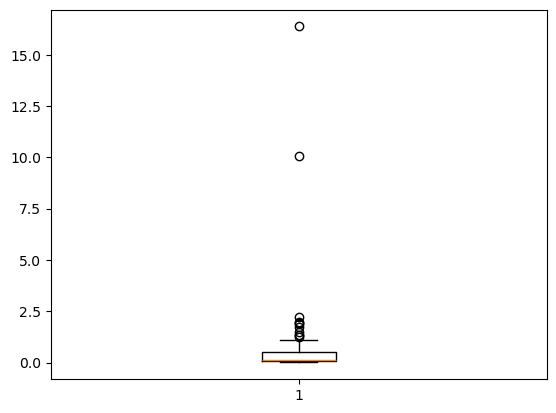

In [193]:
plt.boxplot(diff2)
plt.show()

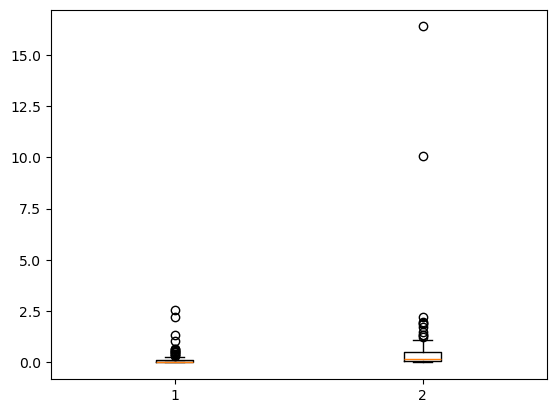

In [194]:
plt.boxplot([diff1,diff2])
plt.show()

## Compare to chatgpt (or other LLM)

In [195]:
df.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50


In [196]:
pickles = glob(dir_api + '*.pickle')
pickles[:3], len(pickles)

(['./example_hists/LLM_outputs/chatgpt_api/id_0039.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0044.pickle',
  './example_hists/LLM_outputs/chatgpt_api/id_0027.pickle'],
 80)

In [197]:
# names subset
pnames = []
for p in pickles:
    pn = p.split('/')[-1].removesuffix('.pickle') + '.jpeg'
    pnames.append(pn)

df2 = df.copy()[df['image file'].isin(np.array(pnames))]

#import sys; sys.exit()

llm_median = []
llm_ngaussian = []
llm_ngaussian_int = []

subset_questions_by_keys = [
    {
        'df flag':'LLM nGaussians',
        'question':'How many gaussians were used to generate the data for the plot in the figure panel?',
        'list':llm_ngaussian
    },
    {
        'question':'What are the median data values  in this figure panel? ',
        'df flag':'LLM Median',
        'list':llm_median
    },
    {
        'df flag':'LLM nGaussians (int)',
        'question':'How many gaussians were used to generate the data for the plot in the figure panel? Please choose an integer number from 1 to 5.',
        'list':llm_ngaussian_int
    }
    ]
#import sys; sys.exit()
#['median', 'ngaussian'] # JPN: this is not efficient
# fill with LLM outputs
for i in range(len(df2)):
    pfile = dir_api + df2.iloc[i]['image file'].removesuffix('.jpeg') + '.pickle'
    with open(pfile, 'rb') as f:
        qa_in = pickle.load(f)[0]

    #import sys; sys.exit()

    for qa_pairs in qa_in: # find right questions
        for subset in subset_questions_by_keys:
            if qa_pairs['question'] == subset['question']:
                ans = qa_pairs['Response']
                try:
                    v = list(ans.values())[0]
                    subset['list'].append(v)
                except:
                    subset['list'].append(np.nan)

for subset in subset_questions_by_keys:
    df2[subset['df flag']] = subset['list']

In [198]:
#qa_in

In [199]:
# just do the part that is a single annotator
df2_a1 = df2[df2['annotators']=='annotator1']
len(df2_a1)

80

In [200]:
df2_a1.head(n=3)

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.490,1
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,3,-0.410,1


(-0.8, 0.9)

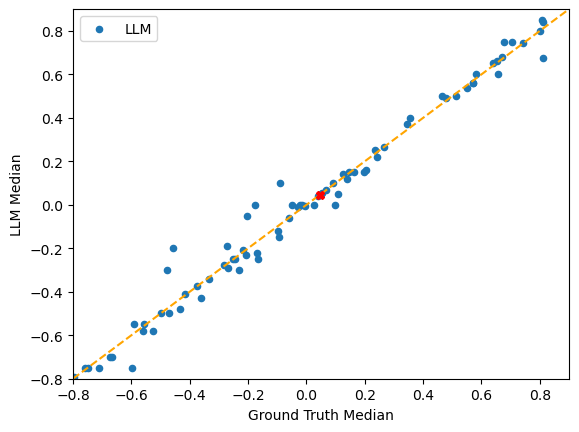

In [201]:
ax = df2_a1.plot(x='Ground Truth Median', y='LLM Median', kind='scatter', label='LLM')

# so we can compare
mxmin = -0.8
mxmax = 0.9

ax.plot([mxmin,mxmax],[mxmin,mxmax], color='orange', linestyle='--')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM Median']
    try:
        llmm = float(llmm)
    except:
        print("FAILED:", llmm)
        llmm = np.nan
    try:
        if np.isnan(llmm):
            gtm = df2_a1.iloc[i]['Ground Truth Median']
            ax.plot([gtm],[gtm], color='red', marker='X')
            #print(gtm)
    except:
        pass
        #print('THIS FAILED:', llmm)

ax.set_ylim(mxmin,mxmax)
ax.set_xlim(mxmin,mxmax)

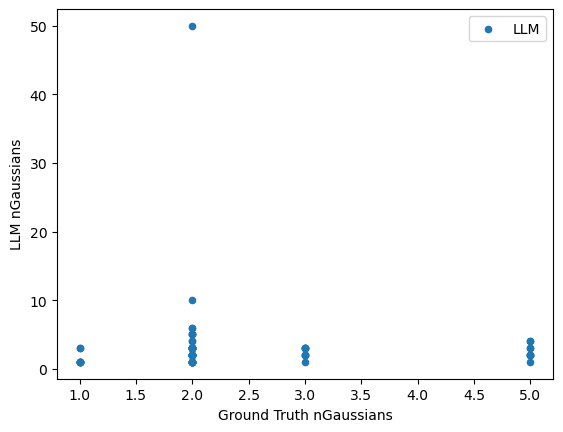

In [202]:
ax = df2_a1.plot(x='Ground Truth nGaussians', y='LLM nGaussians', kind='scatter', label='LLM')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM nGaussians']
    if np.isnan(llmm):
        gtm = df2_a1.iloc[i]['Ground Truth nGaussians']
        ax.plot([gtm],[gtm], color='red', marker='X')
        print(gtm)

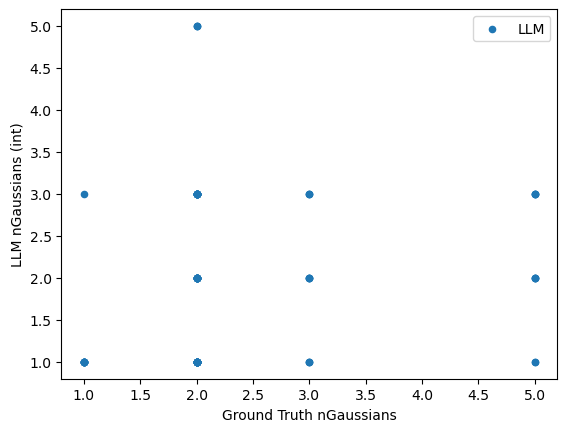

In [203]:
ax = df2_a1.plot(x='Ground Truth nGaussians', y='LLM nGaussians (int)', kind='scatter', label='LLM')
# plot NaNs
for i in range(len(df2_a1)):
    llmm = df2_a1.iloc[i]['LLM nGaussians']
    if np.isnan(llmm):
        gtm = df2_a1.iloc[i]['Ground Truth nGaussians']
        ax.plot([gtm],[gtm], color='red', marker='X')
        print(gtm)

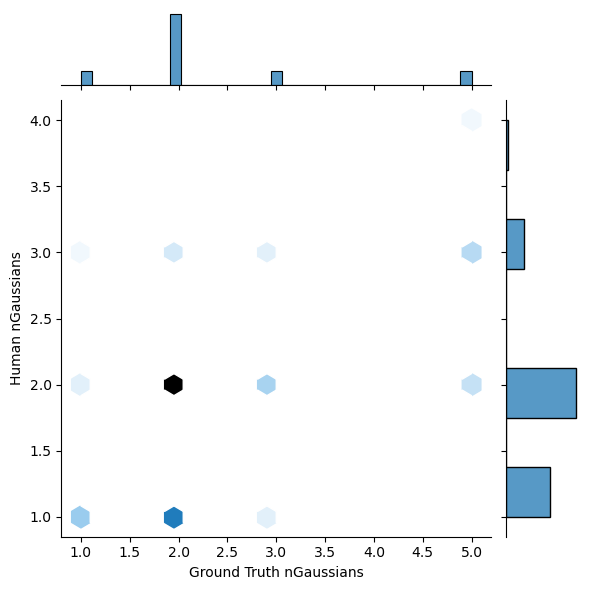

In [204]:
# a different way
sns.jointplot(x='Ground Truth nGaussians', y='Human nGaussians', data=df2_a1, kind='hex')

Some numbers:

In [205]:
diff_llm = (np.abs(df2_a1['Ground Truth Median']-df2_a1['LLM Median']))/np.abs(df2_a1['Ground Truth Median'])

diff_llm = diff_llm[~np.isnan(diff_llm.values)].values

np.mean(diff_llm), np.std(diff_llm)

(0.21621759088098128, 0.3557556724228227)

In [206]:
q1 = np.percentile(diff_llm, 25)
q3 = np.percentile(diff_llm, 75)

iqrl = q3 - q1

np.median(diff_llm), iqrl

(0.06581518350713614, 0.21267269710660702)

In [207]:
np.median(diff1), iqr

(0.0364671267337863, 0.11682488786479395)

## How does accuracy vary across different bar sizes?

```python
nparams = [
    {'nb':10, 'nc':2},
    {'nb':20, 'nc':2},
    {'nb':45, 'nc':2},
    {'nb':60, 'nc':2}, # updated so no overlap
    # different set
    {'nb':50, 'nc':1},
    {'nb':50, 'nc':2}, 
    {'nb':50, 'nc':3},
    {'nb':50, 'nc':5}
]
```

In [249]:
df2.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.490,1
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,3,-0.410,1
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,-0.750,2
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,0.000,1


### Median vs number of bars

In [250]:
dfbars = df2.copy()[df2['Ground Truth nBars'].isin([10,20,45,60])]
# make differences
diffa = np.abs(dfbars['Ground Truth Median']-dfbars['Human median (draw)'])
diffl = np.abs(dfbars['Ground Truth Median']-dfbars['LLM Median'])

dfbars['Diff Median (human)'] = diffa
dfbars['Diff Median (LLM)'] = diffl

In [251]:
dfbars.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
2,annotator1,id_0028.jpeg,2,-0.42,-0.415863,2,-0.417302,45,3,-0.410,1,0.001439,0.007302
5,annotator1,id_0023.jpeg,2,0.80,0.802035,2,0.802090,60,3,0.800,2,0.000055,0.002090
6,annotator1,id_0013.jpeg,1,-0.15,-0.085378,2,-0.097916,60,3,-0.120,1,0.012537,0.022084
7,annotator1,id_0074.jpeg,2,-0.40,-0.428922,2,-0.376166,45,2,-0.375,2,0.052756,0.001166
8,annotator1,id_0017.jpeg,1,0.74,0.738279,2,0.740846,45,1,0.745,1,0.002567,0.004154


In [ ]:
da1 = dfbars[dfbars['annotators']=='annotator1']
da2 = dfbars[dfbars['annotators']=='annotator2']
dl = da1.copy()

In [278]:
da1[da1['Ground Truth nBars']==45]

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
2,annotator1,id_0028.jpeg,2,-0.420,-0.415863,2,-0.417302,45,3,-0.4100,1,0.001439,0.007302
7,annotator1,id_0074.jpeg,2,-0.400,-0.428922,2,-0.376166,45,2,-0.3750,2,0.052756,0.001166
8,annotator1,id_0017.jpeg,1,0.740,0.738279,2,0.740846,45,1,0.7450,1,0.002567,0.004154
11,annotator1,id_0079.jpeg,1,-0.010,-0.002272,2,-0.006342,45,1,-0.0035,1,0.004070,0.002842
26,annotator1,id_0043.jpeg,2,0.125,0.094421,2,0.107690,45,1,0.0500,1,0.013269,0.057690
27,annotator1,id_0060.jpeg,2,-0.600,-0.593485,2,-0.598682,45,2,-0.7500,2,0.005197,0.151318
42,annotator1,id_0024.jpeg,2,-0.100,-0.129759,2,-0.271708,45,2,-0.1900,2,0.141949,0.081708
56,annotator1,id_0066.jpeg,2,0.805,0.811415,2,0.808861,45,1,0.8500,1,0.002554,0.041139
57,annotator1,id_0042.jpeg,1,0.640,0.633811,2,0.640416,45,3,0.6500,2,0.006605,0.009584
60,annotator1,id_0050.jpeg,1,-0.650,-0.652207,2,-0.457787,45,1,-0.2000,1,0.194420,0.257787


<Axes: xlabel='Ground Truth nBars', ylabel='Diff Median (LLM)'>

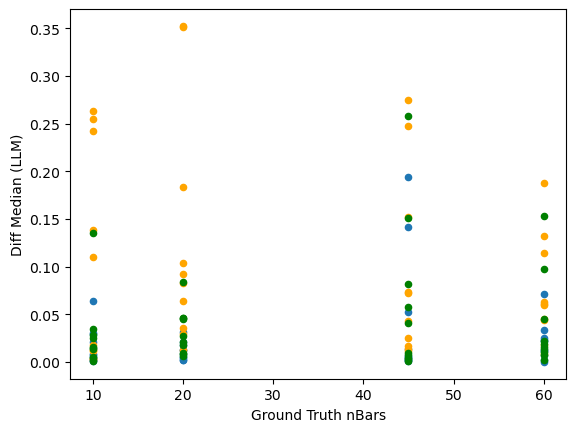

In [ ]:
ax = da1.plot(x='Ground Truth nBars', y='Diff Median (human)', kind='scatter')
da2.plot(x='Ground Truth nBars', y='Diff Median (human)', kind='scatter', color='orange', ax=ax)
dl.plot(x='Ground Truth nBars', y='Diff Median (LLM)', kind='scatter', color='green', ax=ax)

In [268]:
# first annotator
b1 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].median().to_frame()
b1 = b1.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].median().to_frame()
b2 = b2.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].median().to_frame()

dfb = b1.join(b2).join(bl)
dfb

,Diff Median (annotator1),Diff Median (annotator2),Diff Median (LLM)
Ground Truth nBars,,,
10,0.007778,0.063833,0.015364
20,0.010302,0.087342,0.024387
45,0.005901,0.057266,0.025362
60,0.017487,0.059857,0.017069


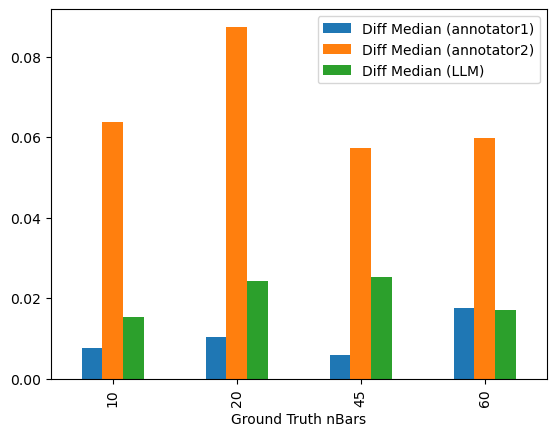

In [275]:
ax = dfb.plot(kind='bar')


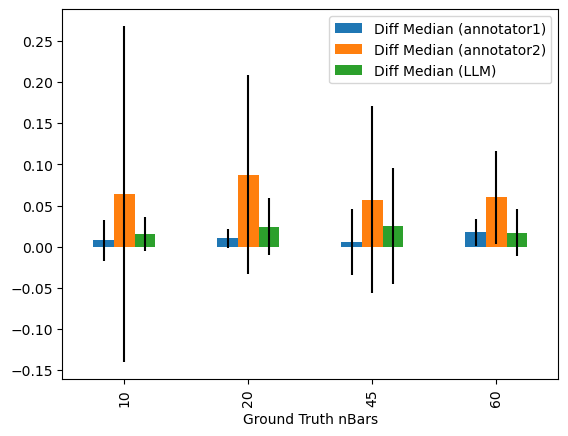

In [276]:
# plot errorbars
errorbars = []
for arr,flag in zip([da1,da2,dl], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    q1 = arr.groupby('Ground Truth nBars')[flag].quantile(0.25)
    q3 = arr.groupby('Ground Truth nBars')[flag].quantile(0.75)
    iqr_d = q3-q1
    errorbars.append(iqr_d)
# q1 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.25)
# q3 = da1.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.75)
# iqr_da1 = q3-q1
# #ax.errorbar(dfb.index.values, dfb['Diff Median (annotator1)'].values, iqr_da1.values)
# q1 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.25)
# q3 = da2.groupby('Ground Truth nBars')['Diff Median (human)'].quantile(0.75)
# iqr_da2 = q3-q1
# # llm
# q1 = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].quantile(0.25)
# q3 = dl.groupby('Ground Truth nBars')['Diff Median (LLM)'].quantile(0.75)
# iqr_dl = q3-q1

ax = dfb.plot(kind='bar', yerr = errorbars) #[iqr_da1,iqr_da2,iqr_dl])


So, pretty big variation across all of these, but not sure how much is real variation and how much is the fact that each of these has small number statistics (10 data points).

In [279]:
dfb.index.values, dfb['Diff Median (annotator1)'].values, errorbars[0].values

(array([10, 20, 45, 60]),
 array([0.00777812, 0.01030201, 0.00590075, 0.01748726]),
 array([0.02471799, 0.01168004, 0.03994086, 0.01617996]))

### Median vs. number of Gaussians

In [255]:
dfbg = df2.copy()[df2['Ground Truth nBars'].isin([50])]
# make differences
diffa_bg = np.abs(dfbg['Ground Truth Median']-dfbg['Human median (draw)'])
diffl_bg = np.abs(dfbg['Ground Truth Median']-dfbg['LLM Median'])

dfbg['Diff Median (human)'] = diffa_bg
dfbg['Diff Median (LLM)'] = diffl_bg

In [256]:
dfbg.head()

,annotators,image file,Human nGaussians,Human median (number),Human median (draw),Ground Truth nGaussians,Ground Truth Median,Ground Truth nBars,LLM nGaussians,LLM Median,LLM nGaussians (int),Diff Median (human),Diff Median (LLM)
0,annotator1,id_0041.jpeg,1,0.055,0.055269,1,0.054428,50,1,0.055,1,0.000841,0.000572
1,annotator1,id_0014.jpeg,3,0.450,0.457472,1,0.478811,50,3,0.490,1,0.021338,0.011189
3,annotator1,id_0057.jpeg,2,-0.700,-0.707283,2,-0.758364,50,2,-0.750,2,0.051081,0.008364
4,annotator1,id_0020.jpeg,1,-0.200,-0.171428,1,-0.178007,50,1,0.000,1,0.006579,0.178007
13,annotator1,id_0075.jpeg,2,-0.690,-0.694032,2,-0.672896,50,3,-0.700,1,0.021136,0.027104


In [ ]:
da1_bg = dfbg[dfbg['annotators']=='annotator1']
da2_bg = dfbg[dfbg['annotators']=='annotator2']
dl_bg = da1_bg.copy()

# ax = da1_bg.plot(x='Ground Truth nGaussians', y='Diff Median (human)', kind='scatter')
# da2_bg.plot(x='Ground Truth nGaussians', y='Diff Median (human)', kind='scatter', color='orange', ax=ax)
# dl_bg.plot(x='Ground Truth nGaussians', y='Diff Median (LLM)', kind='scatter', color='green', ax=ax)

# scatter plot not as useful

In [259]:
# first annotator
b1_bg = da1_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].median().to_frame()
b1_bg = b1_bg.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2_bg = da2_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].median().to_frame()
b2_bg = b2_bg.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl_bg = dl_bg.groupby('Ground Truth nGaussians')['Diff Median (LLM)'].median().to_frame()

dfb_bg = b1_bg.join(b2_bg).join(bl_bg)
dfb_bg

,Diff Median (annotator1),Diff Median (annotator2),Diff Median (LLM)
Ground Truth nGaussians,,,
1,0.002837,0.008822,0.014487
2,0.012598,0.085500,0.013014
3,0.004728,0.036113,0.013026
5,0.036843,0.077561,0.054093


<Axes: xlabel='Ground Truth nGaussians'>

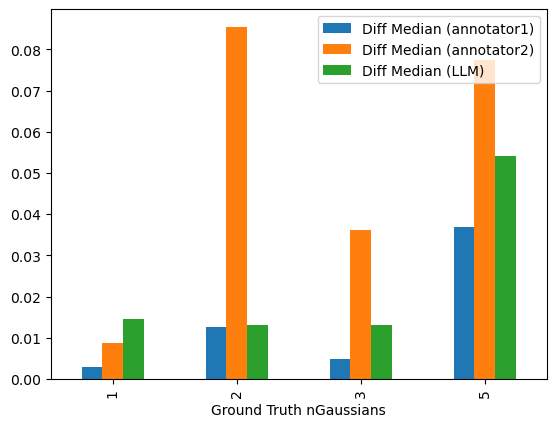

In [261]:
dfb_bg.plot(kind='bar')

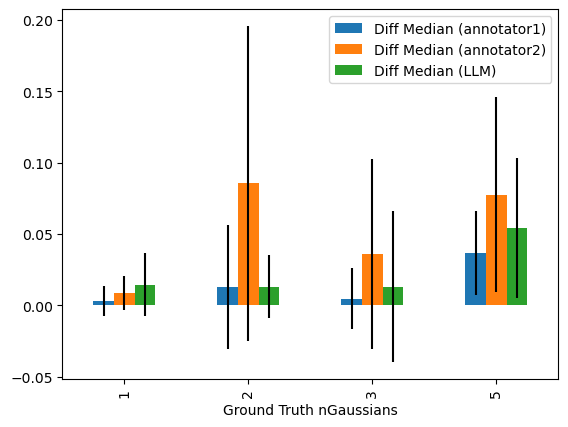

In [281]:
# plot errorbars
errorbars_bg = []
for arr,flag in zip([da1_bg,da2_bg,dl_bg], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    q1 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.25)
    q3 = arr.groupby('Ground Truth nGaussians')[flag].quantile(0.75)
    iqr_d = q3-q1
    errorbars_bg.append(iqr_d)

ax = dfb_bg.plot(kind='bar', yerr = errorbars_bg)

Same deal here with error bars and sample sizes.   Try with mean/STD:

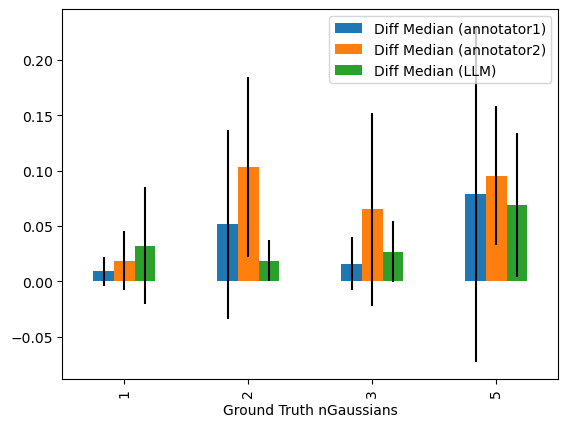

In [286]:
# first annotator
b1_bg2 = da1_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].mean().to_frame()
b1_bg2 = b1_bg2.rename(columns={'Diff Median (human)':'Diff Median (annotator1)'})
# 2nd annotator
b2_bg2 = da2_bg.groupby('Ground Truth nGaussians')['Diff Median (human)'].mean().to_frame()
b2_bg2 = b2_bg2.rename(columns={'Diff Median (human)':'Diff Median (annotator2)'})
# 3rd annotator
bl_bg2 = dl_bg.groupby('Ground Truth nGaussians')['Diff Median (LLM)'].mean().to_frame()

dfb_bg2 = b1_bg2.join(b2_bg2).join(bl_bg2)
#dfb_bg2

errorbars_bg2 = []
for arr,flag in zip([da1_bg,da2_bg,dl_bg], ['Diff Median (human)','Diff Median (human)','Diff Median (LLM)']):
    s1 = arr.groupby('Ground Truth nGaussians')[flag].std()
    errorbars_bg2.append(s1)

ax = dfb_bg2.plot(kind='bar', yerr = errorbars_bg2)

As expected, no big difference between these errorbars and IQR stuffs.